In [20]:
import sys
!{sys.executable} -m pip install pycbc lalsuite ligo-common --no-cache-dir

#### Directly Reading gravitational-wave Frame Files

If you store LIGO data on your own computer then you can directly read in the data as follows.

In [27]:
# We'll first download some data for this demonstration
!curl -O -J -L https://losc.ligo.org/s/events/LVT151012/H-H1_LOSC_4_V2-1128678884-32.gwf

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   266  100   266    0     0    651      0 --:--:-- --:--:-- --:--:--   651
100 1004k  100 1004k    0     0  1330k      0 --:--:-- --:--:-- --:--:-- 1330k


In [28]:
from pycbc.frame import read_frame

# Read the data directly from the Gravitational-Wave Frame (GWF) file.
file_name = "H-H1_LOSC_4_V2-1128678884-32.gwf"

# LOSC bulk data typically uses the same convention for internal channels names
# Strain is typically IFO:LOSC-STRAIN, where IFO can be H1/L1/V1.
channel_name = "H1:LOSC-STRAIN"

start = 1128678884
end = start + 32

ts = read_frame(file_name, channel_name, start, end)

In [29]:
!git clone https://github.com/marcin119a/lstm-pycbc.git
%cd lstm-pycbc

Cloning into 'lstm-pycbc'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (30/30), done.
remote: Total 33 (delta 13), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (33/33), done.
/content/lstm-pycbc


In [97]:
from generator_waveform import generate_wave

apx = 'SEOBNRv4'

params = {
    'approximant':apx,
    'mass1':10,
    'mass2':10,
    'spin1z':0.9,
    'spin2z':0.4,
    'inclination':1.23,
    'coa_phase':2.45,
    'delta_t':1.0/4096,
    'f_lower':40
}
ts, signal_l1, signal_v1 = generate_wave(params)

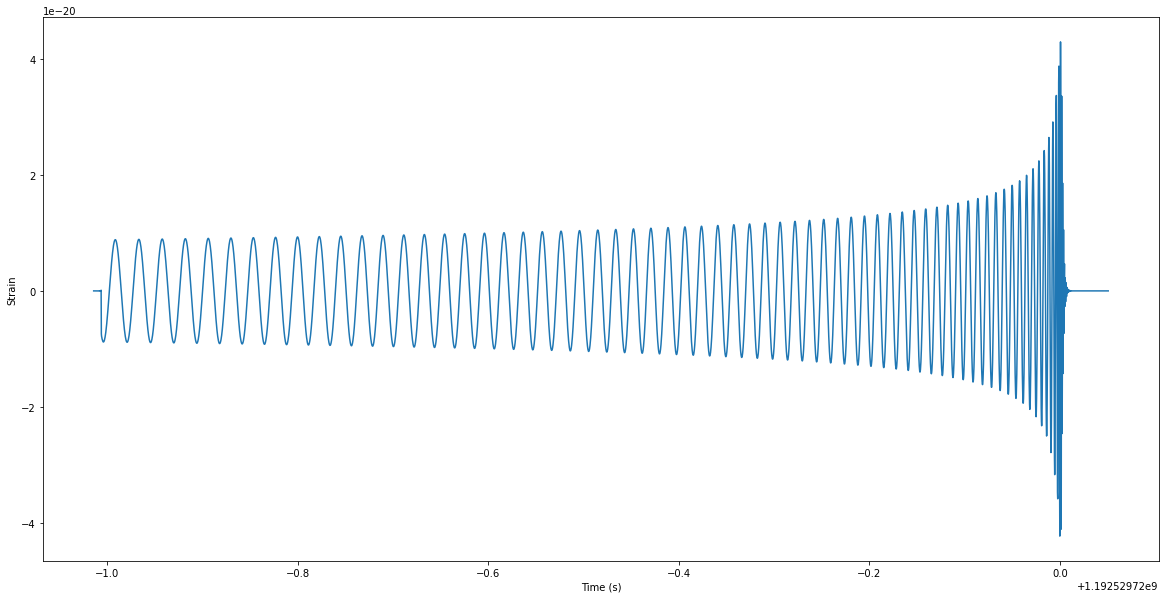

In [98]:
# We can directly plot the time series as follows
pylab.figure(figsize=(20,10))
pylab.plot(ts.sample_times, ts)
pylab.ylabel('Strain')
pylab.xlabel('Time (s)')
pylab.show()

In [99]:
# We can directly plot the time series as follows
from utilities import scaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

dataset = np.array([i for i in ts])
dataset = scaler.fit_transform(dataset.reshape(-1,1))

### The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period - in this case defaulted to 1.

In [100]:
# reshape into X=t(current and Y=t+1(future)
from utilities import create_dataset, split_dataset

look_back = 1
train, test = split_dataset(dataset)
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [sample, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

Training  for the network is trained for 100 epoch and a batch size of 1 is used

In [101]:
from keras.models import Sequential
from keras.layers import (
    Dense, LSTM, RepeatVector, TimeDistributed
)


model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=3, batch_size=1, verbose=2)

Epoch 1/3
2919/2919 - 3s - loss: 0.0202
Epoch 2/3
2919/2919 - 3s - loss: 0.0017
Epoch 3/3
2919/2919 - 3s - loss: 1.1281e-04


In [103]:
import math
from sklearn.metrics import mean_squared_error

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY.reshape(-1,1))
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY.reshape(-1,1))
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY, trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY, testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.00 RMSE
Test Score: 0.00 RMSE


### Plot results:

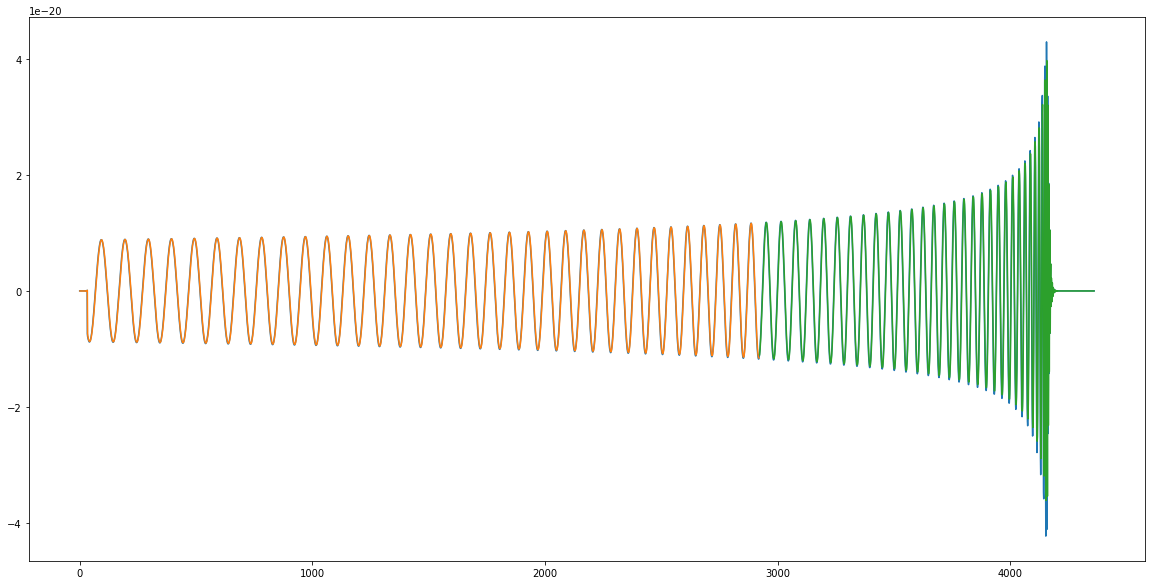

In [104]:
import matplotlib.pyplot as plt
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
pylab.figure(figsize=(20,10))
plt.plot(scaler.inverse_transform(dataset))

plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()